In [1]:
from pathlib import Path
import numpy as np
from turboflow.datasets.turb2D import Turb2D
import matplotlib.pyplot as plt

import torch

In [2]:
data_path = Path('/','home','dicarlo_d','Documents','Datasets','Turb2D.hdf5')
turb2D = Turb2D(data_path)
turb2D.load_data(666)

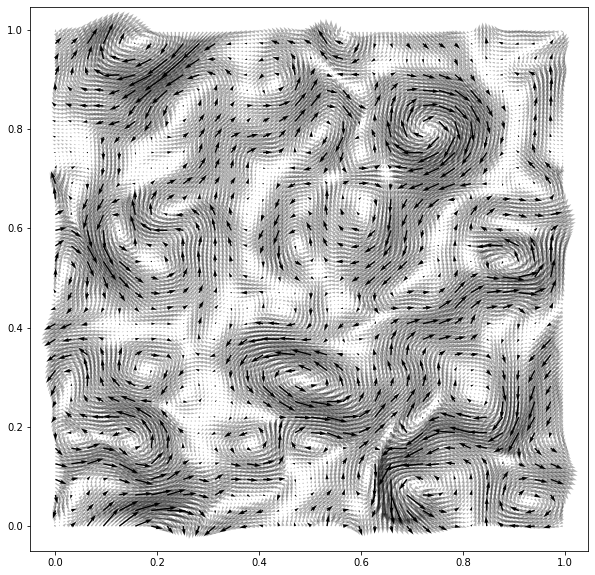

In [3]:
def get_downsampled_data(ds):
    xy = turb2D.xy
    uv = turb2D.uv
    
    xy = xy[::ds, ::ds, :]
    uv = uv[::ds, ::ds, :]
    R = int(xy.shape[0]**.5)
    return xy, uv, R

Xtrain, ytrain, L = get_downsampled_data(ds=8)
Xtest, ytest, H = get_downsampled_data(ds=1)


plt.figure(figsize=(10,10))
ds = 2
plt.quiver(Xtest[:,:,0][::ds,::ds],
           Xtest[:,:,1][::ds,::ds],
           ytest[:,:,0][::ds,::ds],
           ytest[:,:,1][::ds,::ds], alpha=0.3, scale=50)
ds = 1
plt.quiver(Xtrain[:,:,0][::ds,::ds],
           Xtrain[:,:,1][::ds,::ds],
           ytrain[:,:,0][::ds,::ds],
           ytrain[:,:,1][::ds,::ds], alpha=1)
plt.show()

(256, 256, 2)


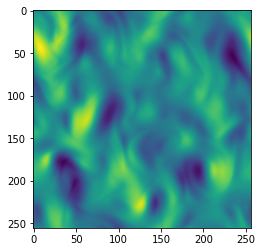

torch.Size([2, 4, 4, 64, 64])
4 4


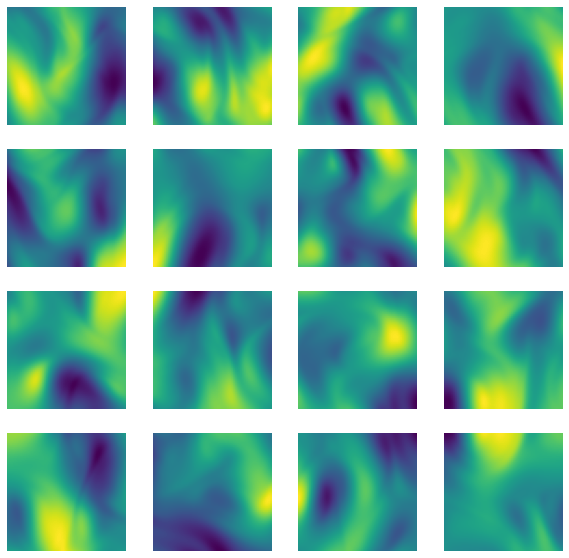

In [77]:
# get patches:
print(Xtest.shape)
x = torch.from_numpy(Xtest.transpose(2,0,1))
y = torch.from_numpy(ytest.transpose(2,0,1))

plt.imshow(y[0,:,:])
plt.show()

size = 64
stride = size
x_patches = x.unfold(1, size, stride).unfold(2, size, stride)
y_patches = y.unfold(1, size, stride).unfold(2, size, stride)
print(y_patches.shape)
nx = y_patches.shape[1]
ny = y_patches.shape[2]

print(nx, ny)

fig, ax = plt.subplots(nx, ny, figsize=(10,10))
ds = 4
for i in range(nx):
    for j in range(ny):
        img = y_patches[0,i,j,:,:]
        ax[i,j].imshow(y_patches[0,i,j,:,:])
#         ax[i,j].quiver(x_patches[0,i,j,:,:][::ds,::ds],
#                        x_patches[1,i,j,:,:][::ds,::ds],
#                        y_patches[0,i,j,:,:][::ds,::ds],
#                        y_patches[1,i,j,:,:][::ds,::ds])
        ax[i,j].axis('off')

In [131]:
from turboflow.models.kernels import DivFreeRBFInterp
model = DivFreeRBFInterp(1000)

y_pred = torch.zeros_like(y_patches)

ds = 8
for i in range(nx):
    for j in range(ny):
        x_train = x_patches[:,i,j,::ds,::ds].permute(1,2,0).reshape(8*8,2)
        y_train = y_patches[:,i,j,::ds,::ds].permute(1,2,0).reshape(8*8,2)
        x_test = x_patches[:,i,j,:,:].permute(1,2,0).reshape(64*64,2)
        y_test = y_patches[:,i,j,:,:].permute(1,2,0).reshape(64*64,2)

        model.fit(x_train.numpy(), y_train.numpy())

        pred = torch.from_numpy(model(x_test.numpy())).view(64,64,2).permute(2,0,1)
        y_pred[:,i,j,:,:] = pred
        
        

#         plt.figure(figsize=(10,10))
#         plt.quiver(x_train[:,0],
#                    x_train[:,1],
#                    y_train[:,0],
#                    y_train[:,1], alpha=0.7)
#         plt.quiver(x_test[:,0],
#                    x_test[:,1],
#                    y_test[:,0],
#                    y_test[:,1], alpha=0.7)
#         plt.quiver(x_test[:,0],
#                    x_test[:,1],
#                    y_pred[:,0],
#                    y_pred[:,1], color='b')
        
#         break

In [132]:
print(y_pred.shape)
y_pred = y_pred.permute(0,1,3,2,4).contiguous()
y_pred = y_pred.view(2,256,256)

torch.Size([2, 4, 4, 64, 64])


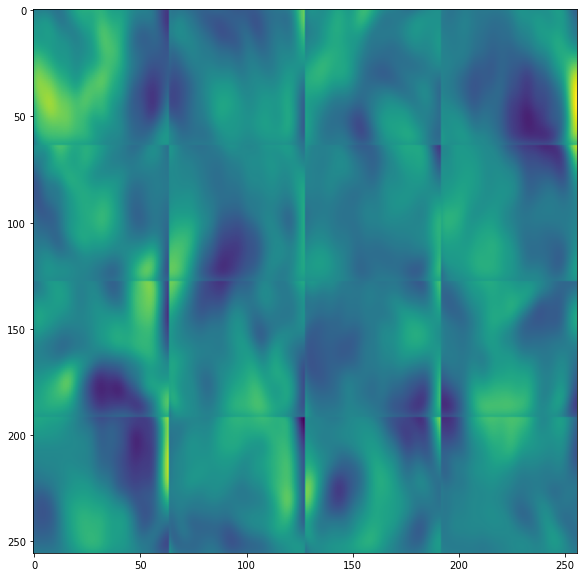

In [133]:
plt.figure(figsize=(10,10))
plt.imshow(y_pred[0,:,:])

(256, 256, 2)


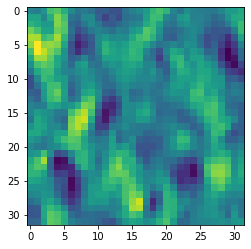

train torch.Size([2, 4, 4, 8, 8])


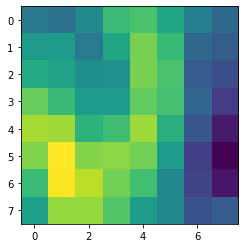

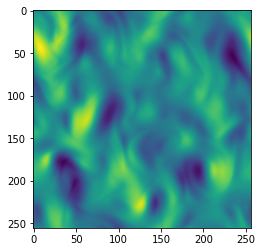

test torch.Size([2, 4, 4, 64, 64])


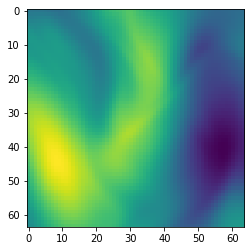

In [174]:
# get patches:
print(Xtest.shape)
ds = 8
x_train = torch.from_numpy(Xtest)[::ds,::ds,:].permute(2,0,1)
y_train = torch.from_numpy(ytest)[::ds,::ds,:].permute(2,0,1)

plt.imshow(y_train[0,:,:])
plt.show()

size = 8
stride = size
x_train_patches = x.unfold(1, size, stride).unfold(2, size, stride)
y_train_patches = y.unfold(1, size, stride).unfold(2, size, stride)
print('train', y_train_patches.shape)
nx = y_train_patches.shape[1]
ny = y_train_patches.shape[2]

plt.imshow(y_train_patches[0,0,0,:,:])
plt.show()

x_test = torch.from_numpy(Xtest).permute(2,0,1)
y_test = torch.from_numpy(ytest).permute(2,0,1)

plt.imshow(y_test[0,:,:])
plt.show()

size = 256//4
stride = size
x_test_patches = x_test.unfold(1, size, stride).unfold(2, size, stride)
y_test_patches = y_test.unfold(1, size, stride).unfold(2, size, stride)
print('test', y_test_patches.shape)

plt.imshow(y_test_patches[0,0,0,:,:])
plt.show()

torch.Size([2, 4, 4, 64, 64])


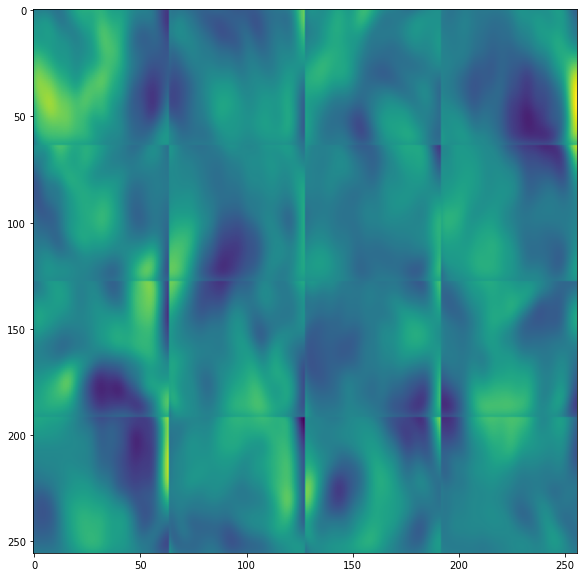

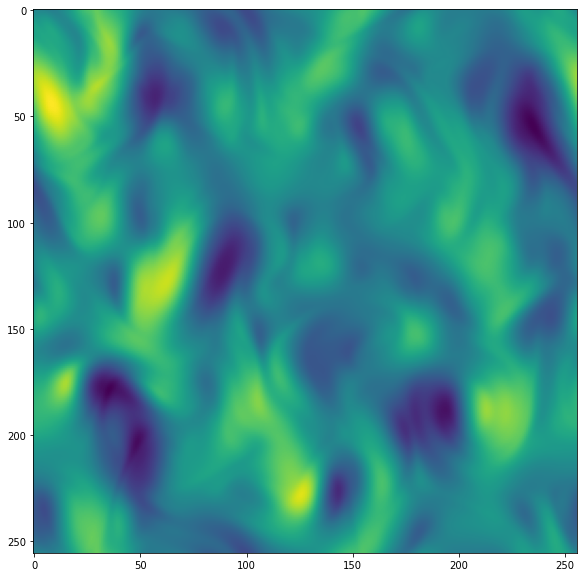

In [175]:
from turboflow.models.kernels import DivFreeRBFInterp
model = DivFreeRBFInterp(1000)

y_pred = torch.zeros_like(y_test_patches)

for i in range(nx):
    for j in range(ny):
        x_train = x_train_patches[:,i,j,:,:].permute(1,2,0).contiguous().view(-1,2)
        y_train = y_train_patches[:,i,j,:,:].permute(1,2,0).contiguous().view(-1,2)
        x_test = x_test_patches[:,i,j,:,:].permute(1,2,0).contiguous().view(-1,2)
        y_test = y_test_patches[:,i,j,:,:].permute(1,2,0).contiguous().view(-1,2)

        model.fit(x_train.numpy(), y_train.numpy())

        pred = torch.from_numpy(model(x_test.numpy())).view(64,64,2).permute(2,0,1)
        y_pred[:,i,j,:,:] = pred
        
print(y_pred.shape)
y_pred = y_pred.permute(0,1,3,2,4).contiguous()
y_pred = y_pred.view(2,256,256)
plt.figure(figsize=(10,10))
plt.imshow(y_pred[0,:,:])
plt.figure(figsize=(10,10))
plt.imshow(ytest[:,:,0])